In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from urllib.request import urlopen
import json
from credentials import get_token
from entsoe import EntsoePandasClient
from entsoe.mappings import lookup_area
from pycaret.time_series import *
mpl.rcParams['figure.dpi'] = 150


In [171]:
country_code = 'GR'

df_countries = pd.read_csv('../countries.csv', index_col = 'country')

lat = df_countries.loc[country_code].latitude.astype('str')
lon = df_countries.loc[country_code].longitude.astype('str')

In [178]:
# Get weather forecast

key = '6af9aae7da2e4596aa0174732220907'
q = lat+','+lon

url = 'http://api.weatherapi.com/v1/forecast.json?key=' + key \
       + '&q=' + q \
       + '&days=3&aqi=no&alerts=no'

response = urlopen(url)

data_json = json.loads(response.read())
df_weather = pd.json_normalize(data_json['forecast']['forecastday'], 'hour')
df_weather.set_index(pd.DatetimeIndex(pd.to_datetime(df_weather['time'])), inplace = True)


In [180]:
# Get historical weather

url = 'https://api.weatherapi.com/v1/history.json?key=' + key \
      + '&q=' + q \
      + '&dt=2022-07-02&end_dt=2022-07-03'

response = urlopen(url)
data_json = json.loads(response.read())
df_weather_hist = pd.json_normalize(data_json['forecast']['forecastday'], 'hour')
df_weather_hist.set_index(pd.DatetimeIndex(pd.to_datetime(df_weather_hist['time'])), inplace = True)

In [55]:
area = lookup_area(country_code)

client = EntsoePandasClient(api_key=get_token())
end = pd.Timestamp.now(tz=area.tz) # - pd.DateOffset(days=10)
start = end - pd.DateOffset(months = 1)
%time df = client.query_generation(area, start=start,end=end, psr_type=None)

Wall time: 5.13 s


In [59]:
df_solar = df['Solar'].to_frame()

df_solar[15:25]

,Solar
2022-06-10 12:00:00+03:00,896.0
2022-06-10 13:00:00+03:00,1081.0
2022-06-10 14:00:00+03:00,1294.0
2022-06-10 15:00:00+03:00,1286.0
2022-06-10 16:00:00+03:00,1115.0
2022-06-10 17:00:00+03:00,787.0
2022-06-10 18:00:00+03:00,0.0
2022-06-10 19:00:00+03:00,0.0
2022-06-10 20:00:00+03:00,0.0
2022-06-10 21:00:00+03:00,0.0


0.4002324979982282

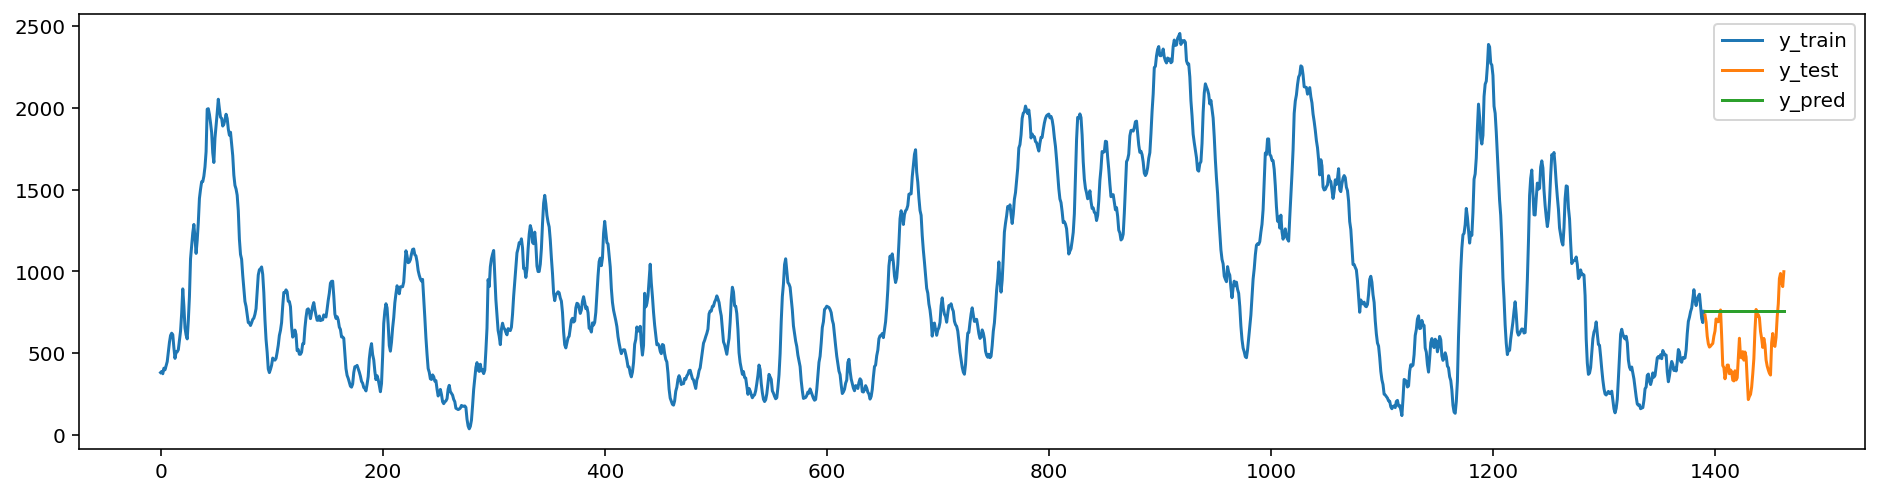

In [4]:
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred = forecaster.predict(forecast_horizon)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

Wall time: 289 ms


0.5375521553173712

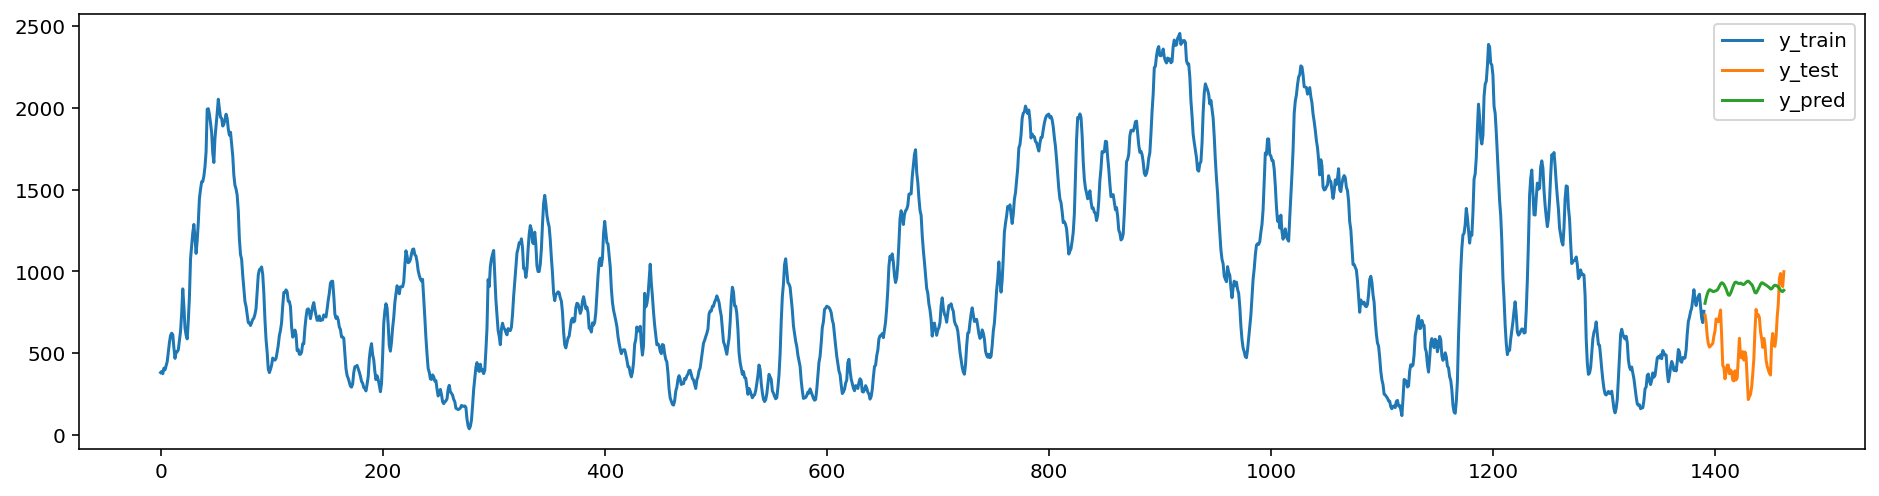

In [5]:
regressor = LinearRegression()
forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=5, strategy='direct')
%time forecaster.fit(y_train, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)

plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

Wall time: 4.64 s


0.5375521553173712

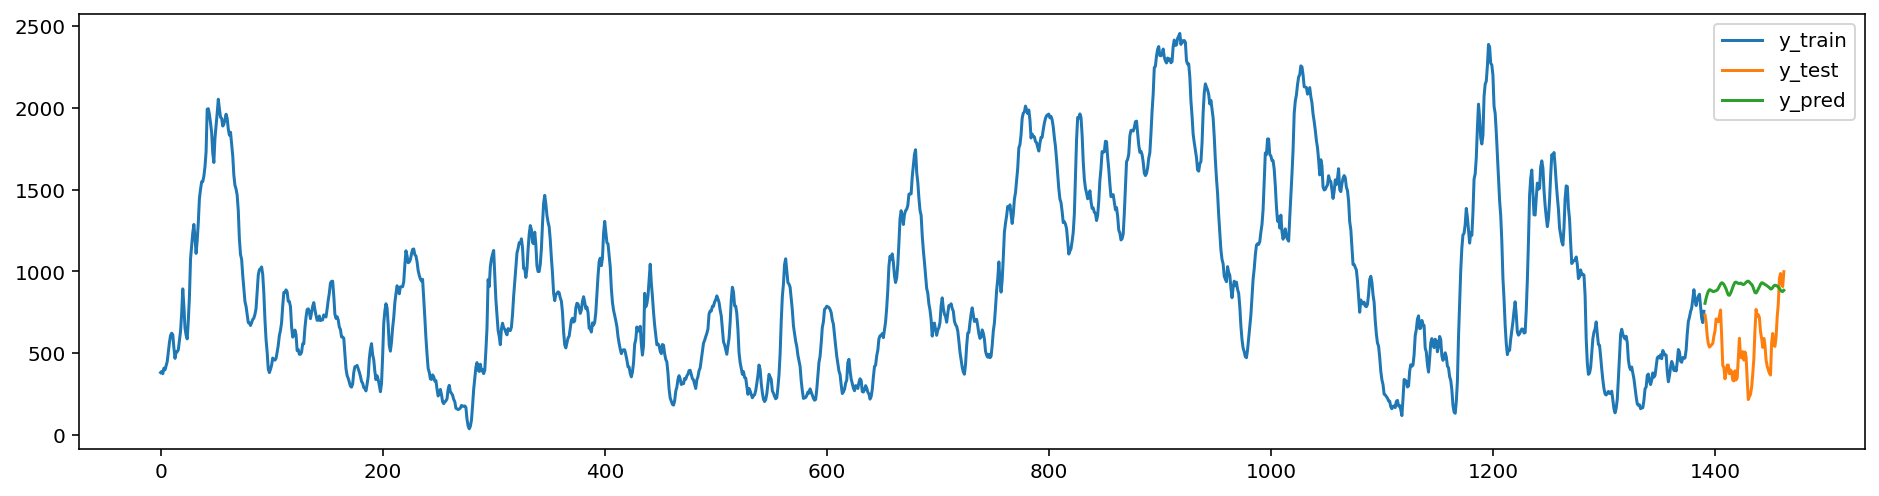

In [6]:
regressor = LinearRegression()
forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=5, strategy='direct')
param_grid = {"window_length": [1, 5, 10, 15]}

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid, n_jobs=8)
%time gscv.fit(y_train, fh=forecast_horizon)
y_pred = gscv.predict(forecast_horizon)

plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)